# Initialization

In [1]:
%load_ext autoreload
%autoreload 2

from jlib.transformer_char_predictor import TransformerCharPredictor, History
import jlib.data_utils as data_utils
import torch
import torch.nn as nn
import numpy as np
from torchprofile import profile_macs
text = data_utils.get_text('data/shakespeare.txt', redownload=False)


/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seqlen = 10
def train_and_plot(seqlen: int):
    data = data_utils.gen_datasets(text, seqlen)
    train_data = data['train_dataset']
    val_data = data['val_dataset']
    alphabet: data_utils.Alphabet = data['alphabet']

    print(len(train_data), len(val_data))
    
    
    train_fetcher = data_utils.gen_data_loader(
        train_data,
        batch_size=len(train_data) // 100,
        workers = 6,
        cpu_prefetch= 5,
        gpu_prefetch=5
    )

    val_fetcher = data_utils.gen_data_loader(
        val_data,
        batch_size=len(val_data) // 16,
        workers = 6,
        cpu_prefetch= 5,
        gpu_prefetch=5,
        shuffle=False,
    )

    # model

    model = TransformerCharPredictor(
        alphabet_size = len(alphabet),
        max_len = seqlen,
        hidden_dim = 128,
        inner_dim = 2048,
        num_attn_heads = 2,
        num_attn_layers=2,
        cls_head_dims=[],
        dropout = 0.4
    )


    hist = model.train_model(
        epochs=50,
        train_fetcher=train_fetcher,
        val_fetcher=val_fetcher,
        optimizer = torch.optim.AdamW,
        optimizer_kwargs={
            'lr': 1e-4,
            'betas': (0.9, 0.98),
            'eps': 1e-9,
            'weight_decay': 1e-5
        },
        sched_factor=1,        
        min_accuracy=1,
        max_negative_diff_count=20,
        stop_on_plateau=True,
        print_epoch=1,
        header_epoch = 15,
    )

    fig = hist.plot_training(f'Shakespeare Corpus, Sequence Length {seqlen}')
    fig.savefig(f'latex/images/p2-{seqlen}.png')
    hist.save(f'models/history/p2-{seqlen}.json')
    hist_load = History.from_json(f'models/history/p2-{seqlen}.json')
    
    del train_fetcher, val_fetcher, train_data, val_data, data, model, alphabet
    





# Training

In [ ]:
train_and_plot(10)


892307 223077
Begin init data loader
Batch Size: 0.6807708740234375 MiB
Data Loader init time: 2.852648 s
Begin init fetcher
Fetcher init time: 2.974773 s
Begin init data loader
Batch Size: 1.063690185546875 MiB
Data Loader init time: 1.596117 s
Begin init fetcher
Fetcher init time: 1.679456 s
Training TransformerCharPredictor

----------------------------------------------------------------------------------------------------------------------------------------------------
Begin Training


/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::unflatten". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::unsqueeze". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::scaled_dot_product_attention". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::permute". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


|       Epoch        |   Epoch Time (s)   |   Training Loss    |  Validation Loss   |Validation Accuracy |   Δ Accuracy (%)   |    Memory Usage    |
----------------------------------------------------------------------------------------------------------------------------------------------------
|         0          |     12.896271      |      3.643323      |      2.946797      |     34.597963      |         inf        |      3.971301      |
----------------------------------------------------------------------------------------------------------------------------------------------------
|         1          |     11.670031      |      3.140253      |      1.977364      |     65.555346      |     89.477470      |      4.006457      |
----------------------------------------------------------------------------------------------------------------------------------------------------
|         2          |     11.589228      |      2.596017      |      1.126566      |     82.159567      |

42491 10623
Begin init data loader
Batch Size: 0.064697265625 MiB
Data Loader init time: 0.229655 s
Begin init fetcher
Fetcher init time: 0.370808 s
Begin init data loader
Batch Size: 0.101165771484375 MiB
Data Loader init time: 0.265586 s
Begin init fetcher
Fetcher init time: 0.430146 s
Training TransformerCharPredictor

----------------------------------------------------------------------------------------------------------------------------------------------------
Begin Training


/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::unflatten". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::unsqueeze". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::scaled_dot_product_attention". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::permute". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


|       Epoch        |   Epoch Time (s)   |   Training Loss    |  Validation Loss   |Validation Accuracy |   Δ Accuracy (%)   |    Memory Usage    |
----------------------------------------------------------------------------------------------------------------------------------------------------
|         0          |      2.245794      |      3.700022      |      3.243513      |     24.097712      |         inf        |      0.700324      |
----------------------------------------------------------------------------------------------------------------------------------------------------
|         1          |      2.012632      |      3.395077      |      3.016303      |     31.277418      |     29.794138      |      0.700324      |
----------------------------------------------------------------------------------------------------------------------------------------------------
|         2          |      1.911604      |      3.189737      |      2.458904      |     50.209922      |

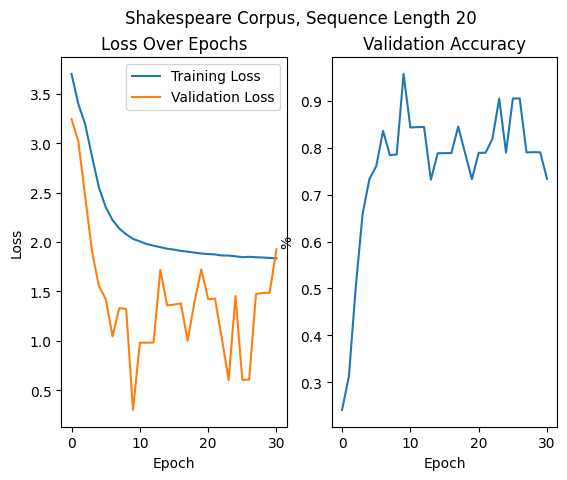

In [ ]:
train_and_plot(20)


28784 7196
Begin init data loader
Batch Size: 0.0656890869140625 MiB
Data Loader init time: 0.289435 s
Begin init fetcher
Fetcher init time: 0.442240 s
Begin init data loader
Batch Size: 0.1027679443359375 MiB
Data Loader init time: 0.257011 s
Begin init fetcher
Fetcher init time: 0.406920 s
Training TransformerCharPredictor

----------------------------------------------------------------------------------------------------------------------------------------------------
Begin Training


/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::unflatten". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::unsqueeze". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::scaled_dot_product_attention". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/jaskin/Intro_Deep_Learning/env/lib/python3.11/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::permute". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


|       Epoch        |   Epoch Time (s)   |   Training Loss    |  Validation Loss   |Validation Accuracy |   Δ Accuracy (%)   |    Memory Usage    |
----------------------------------------------------------------------------------------------------------------------------------------------------
|         0          |      2.142523      |      3.692669      |      3.279737      |     22.973874      |         inf        |      0.805797      |
----------------------------------------------------------------------------------------------------------------------------------------------------
|         1          |      1.979066      |      3.447780      |      3.190825      |     25.258940      |      9.946368      |      0.805797      |
----------------------------------------------------------------------------------------------------------------------------------------------------
|         2          |      1.946842      |      3.342787      |      2.772746      |     38.270336      |

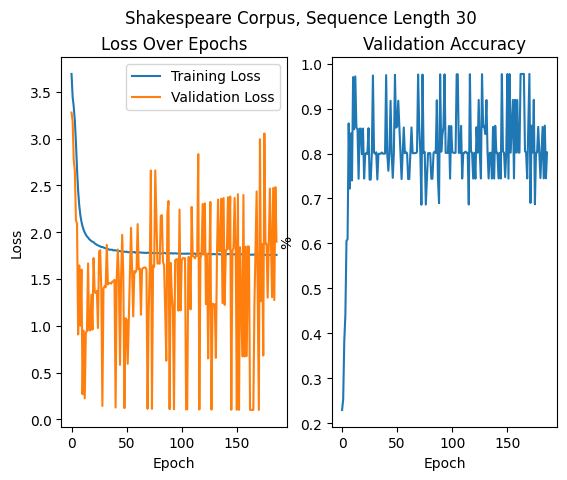

In [ ]:
train_and_plot(30)
